In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
from tqdm import tqdm

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb #BDT

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
samples = ["ttw", "ttz"]

df = []
for sample in samples:
    # Retrieve TTree
    f = uproot.open("hadds/extraJetsPreprocBDT_Run2/{}.root".format(sample))
    tree = f.get("variable")
    temp_df = tree.pandas.df(branches=["MVA_*"], flatten=True)
    df.append(temp_df)

df = pd.concat(df)
# Remove "MVA" prefix from column names
df.columns = df.columns.str.split("MVA_").str.get(1)

In [3]:
# Make a preliminary cut on Mjj
# df = df[np.abs(df.extra_jet_pair_M - 80.379) < 30]

In [4]:
# Get columns (e.g. bookkeeping) to exclude in training
excludes = [
    "run", 
    "event", 
    "lumi", 
    "extra_jet_pair_is_match", 
    "bjet_pair_ld_deepjet",
    "bjet_pair_tr_deepjet",
    "bjet_pair_ld_eta",
    "bjet_pair_tr_eta",
    "bjet_pair_ld_phi",
    "bjet_pair_tr_phi",
    "lep_pair_ld_id",
    "lep_pair_tr_id",
    "lep_pair_ld_eta",
    "lep_pair_tr_eta",
    "vbs_pair_ld_eta",
    "vbs_pair_tr_eta",
    "extra_jet_pair_ld_deepjet",
    "extra_jet_pair_tr_deepjet",
]
    
# Collect selected features
features = sorted(list(set(df.columns.values)-set(excludes)))

In [5]:
print("-- Features selected -- \n")
print("    "+"\n  + ".join(features))
print("  __"+"".join("_" for _ in range(max([len(s) for s in features]))))
print("  = {} total features".format(len(features)))

-- Features selected -- 

    MET_phi
  + MET_pt
  + bjet_pair_ld_pt
  + bjet_pair_tr_pt
  + extra_jet_pair_M
  + extra_jet_pair_dR
  + extra_jet_pair_ld_bjet_M
  + extra_jet_pair_ld_bjet_dR
  + extra_jet_pair_ld_bjet_pt
  + extra_jet_pair_ld_eta
  + extra_jet_pair_ld_lep_M
  + extra_jet_pair_ld_lep_dR
  + extra_jet_pair_ld_lep_pt
  + extra_jet_pair_ld_phi
  + extra_jet_pair_ld_pt
  + extra_jet_pair_ld_qg_disc
  + extra_jet_pair_pt
  + extra_jet_pair_tr_bjet_M
  + extra_jet_pair_tr_bjet_dR
  + extra_jet_pair_tr_bjet_pt
  + extra_jet_pair_tr_eta
  + extra_jet_pair_tr_lep_M
  + extra_jet_pair_tr_lep_dR
  + extra_jet_pair_tr_lep_pt
  + extra_jet_pair_tr_phi
  + extra_jet_pair_tr_pt
  + extra_jet_pair_tr_qg_disc
  + lep_pair_ld_phi
  + lep_pair_ld_pt
  + lep_pair_tr_phi
  + lep_pair_tr_pt
  + vbs_pair_ld_phi
  + vbs_pair_ld_pt
  + vbs_pair_tr_phi
  + vbs_pair_tr_pt
  ___________________________
  = 35 total features


/home/users/jguiang/.local/lib/python2.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <type 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


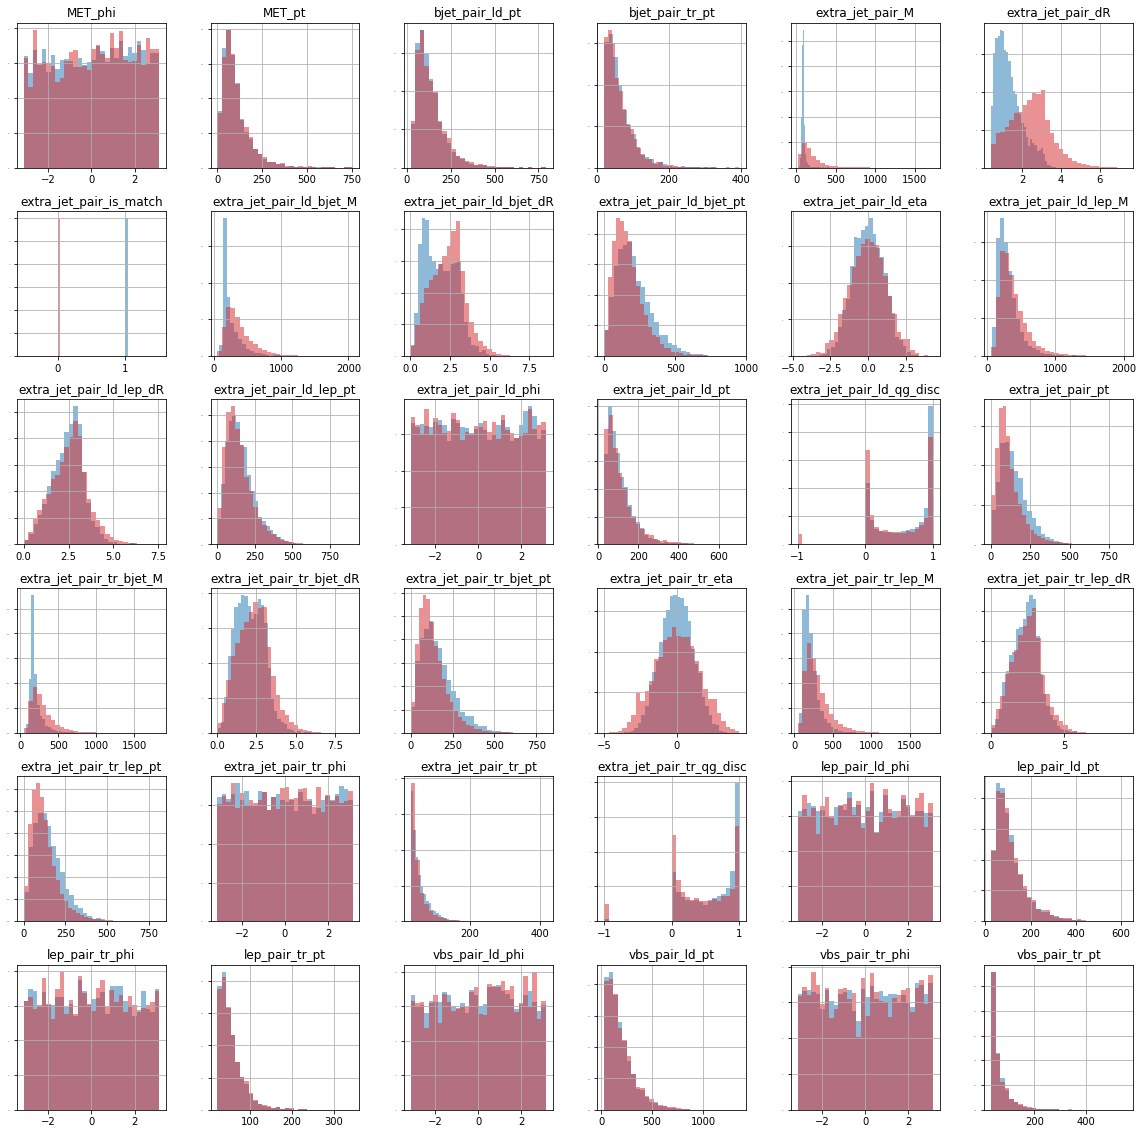

In [6]:
extras = ["extra_jet_pair_is_match"]

fig, axes = plt.subplots(6,6,figsize=(20,20))
df[df.extra_jet_pair_is_match][features + extras].hist(
    ax=axes.flatten()[:len(features + extras)], 
    alpha=0.5, 
    color="C0", 
    ylabelsize=0, 
    density=True, 
    bins=30
);
df[~df.extra_jet_pair_is_match][features + extras].hist(
    ax=axes.flatten()[:len(features + extras)], 
    alpha=0.5, 
    color="C3", 
    ylabelsize=0, 
    density=True, 
    bins=30
);

In [7]:
# Split dataframe for training and testing
dummy_weights = np.ones(df.extra_jet_pair_is_match.size) # in place of dfs["weights"]
x_train, x_test, y_train, y_test, weights_train, weights_test = train_test_split(
    df,
    df.extra_jet_pair_is_match,
    dummy_weights,
    test_size=0.25, 
    random_state=42,
)

print("Training Data: {}".format(x_train.shape))
print("Testing Data: {}".format(x_test.shape))

Training Data: (17409, 53)
Testing Data: (5803, 53)


In [8]:
events_train, events_test = train_test_split(df.event.unique(), test_size=0.25, random_state=42)

In [9]:
x_train = df[np.isin(df.event, events_train)]
y_train = x_train.extra_jet_pair_is_match
weights_train = np.ones(y_train.size)
x_test = df[np.isin(df.event, events_test)]
y_test = x_test.extra_jet_pair_is_match
weights_test = np.ones(y_test.size)

print("Training Data: {}".format(x_train.shape))
print("Testing Data: {}".format(x_test.shape))

Training Data: (17147, 53)
Testing Data: (6065, 53)


### Previously Used BDT Knobs (Parameters)

```python
num_round = 200                 # Number of training rounds
param['eta'] = 0.1              # Step size shrinkage (alias: learning_rate)
param['max_depth'] = 3          # Max. depth of tree: larger = more complex = more prone to overfitting
param['verbosity'] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
param['nthread'] = 12           # Number of parallel threads
param['eval_metric'] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the Curve
param['subsample'] = 0.6        # Subsample ratio of the training instances
param['alpha'] = 8.0            # L1 regularization term on weights: Larger = more conservative
param['gamma'] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
param['lambda'] = 1.0           # L2 regularization term on weights: Larger = more conservative
param['min_child_weight'] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
param['colsample_bytree'] = 1.0 # The subsample ratio of columns when constructing each tree

bdt = xgb.train(param.items(), dtrain, num_round, evallist, early_stopping_rounds=15, verbose_eval=True)
```

In [10]:
# BDT Input
dtrain = xgb.DMatrix(x_train[features], label=y_train, weight=np.abs(weights_train))
dtest = xgb.DMatrix(x_test[features], label=y_test, weight=np.abs(weights_test))
evallist = [(dtrain,'train'), (dtest,'eval')]

# BDT Parameters Setup
orig_param = {}
orig_param['objective'] = 'binary:logistic'

# BDT Knobs (Parameters)
num_round = 200                       # Number of training rounds
orig_param['eta'] = 0.1               # Step size shrinkage (alias: learning_rate)
orig_param['max_depth'] = 3           # Max. depth of tree: larger = more complex = more prone to overfitting
orig_param['verbosity'] = 1           # 0 (silent), 1 (warning), 2 (info), 3 (debug)
orig_param['nthread'] = 12            # Number of parallel threads
orig_param['eval_metric'] = "auc"     # Evaluation metrics for validation data. 'auc' = Area Under the Curve
orig_param['subsample'] = 0.6         # Subsample ratio of the training instances
orig_param['alpha'] = 9.0             # L1 regularization term on weights: Larger = more conservative
orig_param['gamma'] = 8.5             # Min. loss rediction to make leaf (alias: min_split_loss)
orig_param['lambda'] = 1.0            # L2 regularization term on weights: Larger = more conservative
orig_param['min_child_weight'] = 50.0 # Minimum sum of instance weight (hessian) needed in a child
orig_param['colsample_bytree'] = 1.0  # The subsample ratio of columns when constructing each tree

# Train
bdt = xgb.train(orig_param.items(), dtrain, num_round, evallist, early_stopping_rounds=15, verbose_eval=True)

[0]	train-auc:0.87016	eval-auc:0.857253
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 15 rounds.
[1]	train-auc:0.873789	eval-auc:0.860938
[2]	train-auc:0.882614	eval-auc:0.869563
[3]	train-auc:0.889782	eval-auc:0.878183
[4]	train-auc:0.891003	eval-auc:0.878742
[5]	train-auc:0.891472	eval-auc:0.87925
[6]	train-auc:0.901307	eval-auc:0.892155
[7]	train-auc:0.902852	eval-auc:0.893892
[8]	train-auc:0.903716	eval-auc:0.894117
[9]	train-auc:0.90453	eval-auc:0.896542
[10]	train-auc:0.905864	eval-auc:0.898402
[11]	train-auc:0.907416	eval-auc:0.89971
[12]	train-auc:0.909777	eval-auc:0.901617
[13]	train-auc:0.910118	eval-auc:0.902393
[14]	train-auc:0.911505	eval-auc:0.903373
[15]	train-auc:0.913435	eval-auc:0.904948
[16]	train-auc:0.913701	eval-auc:0.905426
[17]	train-auc:0.913994	eval-auc:0.905851
[18]	train-auc:0.914327	eval-auc:0.906138
[19]	train-auc:0.914511	eval-auc:0.906183
[20]	train-auc:0.91536	eval-auc:0

[192]	train-auc:0.935918	eval-auc:0.92372
[193]	train-auc:0.935918	eval-auc:0.92372
[194]	train-auc:0.935918	eval-auc:0.92372
[195]	train-auc:0.935918	eval-auc:0.92372
[196]	train-auc:0.935918	eval-auc:0.92372
[197]	train-auc:0.935918	eval-auc:0.92372
[198]	train-auc:0.935918	eval-auc:0.92372
[199]	train-auc:0.936002	eval-auc:0.923832


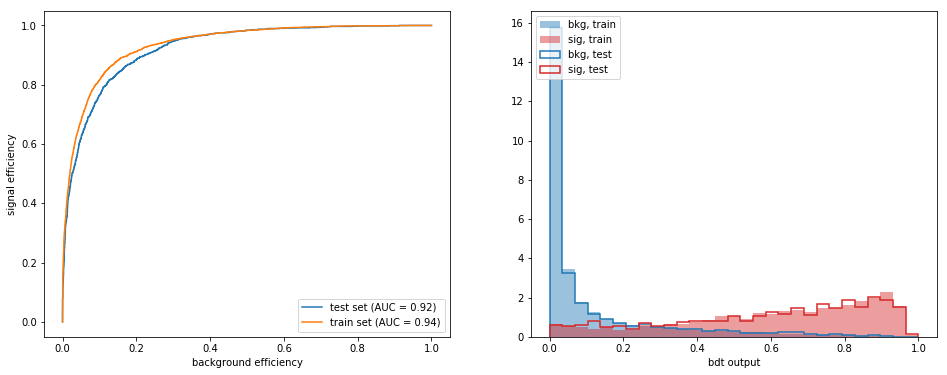

In [11]:
from bdt_diagnostics import plot_bdt_performance, get_top_bdt_cuts

plot_bdt_performance(bdt, x_train, x_test, y_train, y_test, features)

In [12]:
scores_top15 = get_top_bdt_cuts(bdt)
scores_top15

,cut,gain,cover,weight
1,extra_jet_pair_M,167.450108,1024.569198,104
5,extra_jet_pair_pt,164.893387,903.257955,3
11,extra_jet_pair_tr_pt,72.832525,826.641538,24
26,extra_jet_pair_dR,44.737937,941.828451,33
6,extra_jet_pair_ld_pt,43.437019,817.469577,18
18,extra_jet_pair_ld_bjet_M,26.041724,560.494296,60
15,extra_jet_pair_tr_bjet_M,25.517983,650.158119,57
16,extra_jet_pair_tr_qg_disc,24.009857,843.209904,33
27,extra_jet_pair_ld_qg_disc,22.442178,750.099124,24
7,extra_jet_pair_ld_bjet_dR,22.370499,658.298591,11


In [13]:
# Write BDT model and test data to pickle file
pickle.dump(bdt, open("kitchen_sink_bdt.pkl", "w"))
x_test.to_pickle("kitchen_sink_x_test.pkl", compression="gzip")
# Write BDT model to JSON
bdt.save_model("kitchen_sink_bdt.json")
# Write features to JSON
with open("kitchen_sink_features.json", "w") as fout:
    json.dump(features, fout)
# Write scores table as LaTeX system
with open("kitchen_sink_vars.tex", "w") as fout:
    fout.write(scores_top15.to_latex())

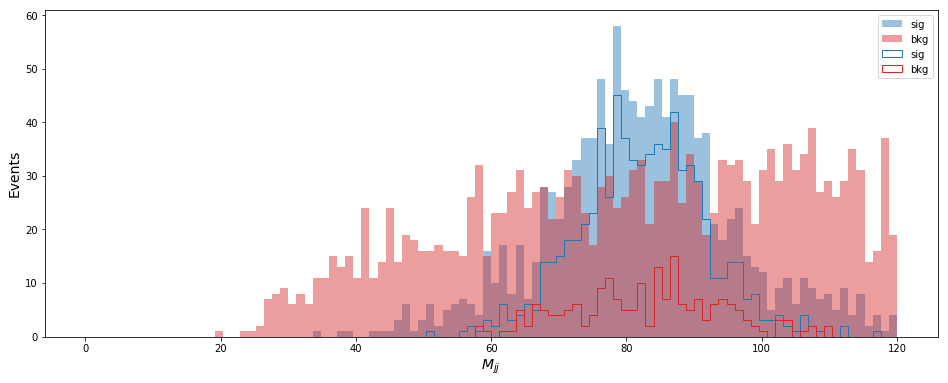

In [14]:
# Get predictions
preds_train = bdt.predict(xgb.DMatrix(x_train[features]))
preds_test = bdt.predict(xgb.DMatrix(x_test[features]))

# Suplots setup
fig, axes = plt.subplots(1,1,figsize=(16,6))
bins = np.linspace(0, 120, 101)

# Subplot 1: Plot correlation btwn predictions and Higgs mass
plt.subplot(1, 1, 1)
# Correlation btwn predictions and Higgs mass
plt.hist(
    x_test["extra_jet_pair_M"][y_test == 1], 
    bins=bins, 
    histtype="stepfilled",
    alpha=0.45, 
    label="sig",
    color="C0"
)
plt.hist(
    x_test["extra_jet_pair_M"][y_test == 0], 
    bins=bins, 
    histtype="stepfilled",
    alpha=0.45, 
    label="bkg",
    color="C3"
)
plt.hist(
    x_test["extra_jet_pair_M"][(preds_test > 0.6) & (y_test == 1)], 
    bins=bins, 
    histtype="step",
    alpha=1.0, 
    label="sig",
    color="C0"
)
plt.hist(
    x_test["extra_jet_pair_M"][(preds_test > 0.6) & (y_test == 0)], 
    bins=bins, 
    histtype="step",
    alpha=1.0, 
    label="bkg",
    color="C3"
)
# Settings
plt.xlabel("$M_{jj}$", size=14);
plt.ylabel("Events", size=14);
plt.legend();

In [15]:
from param_scan import XGBoostParamScan

In [16]:
# Initialize parameter scan object
param_scan = XGBoostParamScan(x_train[features], x_test[features], y_train, y_test, features)
print("\n -- Scan initialized -- \n")
# Add variable parameters
param_scan.addParam("max_depth", [3])
param_scan.addParam("alpha", np.linspace(0.0, 2.5, 11))
param_scan.addParam("lambda", np.linspace(1.0, 2.0, 11))
param_scan.addParam("eta", np.linspace(0.2, 0.5, 5))
param_scan.addParam("gamma", np.linspace(0.0, 2.0, 11))
param_scan.addParam("subsample", np.linspace(0.3, 0.6, 9))
# Add constant parameters
sumw_pos = np.abs(param_scan.dtrain.get_weight()[param_scan.dtrain.get_label()==1]).sum()
sumw_neg = np.abs(param_scan.dtrain.get_weight()[param_scan.dtrain.get_label()==1]).sum()
param_scan.addParam("scale_pos_weight", [sumw_neg/sumw_pos])
param_scan.addParam("min_child_weight", [200.0])

n_configs = len(param_scan.param_configs)
param_scan.print_summary()
print("    At 10 it/sec, this will take {0} minutes ({1} hours).".format(n_configs/10./60., n_configs/10./60./60.))


 -- Scan initialized -- 

  + scale_pos_weight (1 values)
  + min_child_weight (1 values)
  + subsample (9 values)
  + eta (5 values)
  + alpha (11 values)
  + max_depth (1 values)
  + gamma (11 values)
  + lambda (11 values)
  _________________________________
  = 59895 total configurations
    At 10 it/sec, this will take 99.825 minutes (1.66375 hours).
